In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow import keras
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Dropout

In [18]:
train_dir = r"/content/PLANT_VILLAGE_SPLIT/train"
test_dir = r"/content/PLANT_VILLAGE_SPLIT/test"
val_dir = r"/content/PLANT_VILLAGE_SPLIT/val"

In [19]:
IMAGE_SIZE = (224, 224) # Compatible with the input size the pre-trained model was trained on
BATCH_SIZE = 16

In [20]:
def rgb_to_hsv(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)  # Converting RGB to HSV
    return hsv_image

def preprocess_function(image):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image

In [21]:
datagen = ImageDataGenerator(rescale=1.0/255,
                             preprocessing_function=preprocess_function)

In [22]:
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 32572 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.
Found 10885 images belonging to 38 classes.


In [37]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model

def lightweight_unet_classification(input_shape=(224, 224, 3), num_classes=38):
    inputs = Input(input_shape)

    # Encoder (Feature Extraction)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    # Global Average Pooling for Lightweight Classification
    f = GlobalAveragePooling2D()(c5)
    f = BatchNormalization()(f)
    f = Dense(256, activation='relu')(f)
    f = Dropout(0.3)(f)
    outputs = Dense(num_classes, activation='softmax')(f)

    model = Model(inputs, outputs)
    return model

# Create the model
model = lightweight_unet_classification()

In [38]:
model.compile(tf.keras.optimizers.Adam(learning_rate = 0.001), # Learning rate of 0.001 was set after test training multiple times with different values
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [39]:
model.build(input_shape=(None, 224, 224, 3))
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 224, 224, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 112, 112, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 112, 112, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 56, 56, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 28, 28, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_48 (Conv2D)                   │ (None, 14, 14, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_49 (Conv2D)                   │ (None, 14, 14, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 38)                  │           9,766 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 1,255,350 (4.79 MB)

 Trainable params: 1,254,838 (4.79 MB)

 Non-trainable params: 512 (2.00 KB)

In [40]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=5, restore_best_weights=True) # min_delta was chosen 0.005 after multiple testing with different values

In [41]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 179s 84ms/step - accuracy: 0.3373 - loss: 2.4119 - val_accuracy: 0.7152 - val_loss: 0.9385
Epoch 2/50
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 168s 83ms/step - accuracy: 0.7328 - loss: 0.8528 - val_accuracy: 0.6979 - val_loss: 1.0250
Epoch 3/50
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 175s 86ms/step - accuracy: 0.8044 - loss: 0.6133 - val_accuracy: 0.8519 - val_loss: 0.4824
Epoch 4/50
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 166s 81ms/step - accuracy: 0.8439 - loss: 0.4899 - val_accuracy: 0.8746 - val_loss: 0.4051
Epoch 5/50
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 166s 82ms/step - accuracy: 0.8671 - loss: 0.4108 - val_accuracy: 0.8769 - val_loss: 0.3915
Epoch 6/50
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 167s 82ms/step - accuracy: 0.8869 - loss: 0.3455 - val_accuracy: 0.8863 - val_loss: 0.3687
Epoch 7/50
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 165s 81ms/step - accuracy: 0.8960 - loss: 0.3243 - val_accuracy: 0.8462 - val_loss: 0.5284
Epoch 8/50
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 169s 83ms/step - accuracy: 

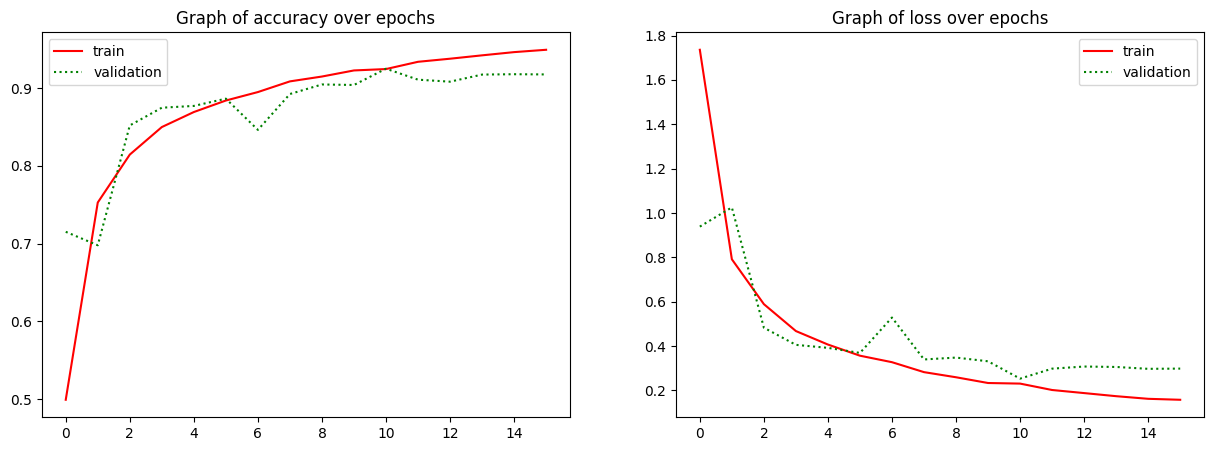

In [42]:
def printplot(history):
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history["accuracy"], color="red", label="train")
        plt.plot(history.history["val_accuracy"], color="green", label="validation", linestyle=":")
        plt.title("Graph of accuracy over epochs")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history["loss"], color="red", label="train")
        plt.plot(history.history["val_loss"], color="green", label="validation", linestyle=":")
        plt.title("Graph of loss over epochs")
        plt.legend()

printplot(history)

In [43]:
model.save("UNET.h5")

In [44]:
# Evaluate model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

681/681 ━━━━━━━━━━━━━━━━━━━━ 36s 53ms/step - accuracy: 0.9245 - loss: 0.2731
Test Accuracy: 92.71%
Test Loss: 0.2462
